# Homework set 3

(Due Mar 3., 2023 at Noon)

Submit your solution notebook in your directory via github PR.

## Problem 1 (100 pts)

Our Colloquium speaker a couple of weeks ago, Ashley Villar, has had to use MCMC extensively. She had something like 5,243 objects from Pan-STARRS to analyze after all (https://zenodo.org/record/3974950)

You'll only have to deal with two - the two that are in this directory

In [1]:
!ls *snana.dat

PS1_PS1MD_PSc000098.snana.dat PS1_PS1MD_PSc000174.snana.dat


She used equation 1, defined here: https://arxiv.org/abs/1905.07422

# $ F= \begin{cases}\frac{A+\beta\left(t-t_0\right)}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t<t_1 \\ \frac{\left(A+\beta\left(t_1-t_0\right)\right) e^{-\left(t-t_1\right) / \tau_{\text {fall }}}}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t \geq t_1\end{cases} $

to model the *flux*, $F$, of a supernova in some band, at times, $t$.

You can see the fits Ashley derived here:

<img src="examples.jpg">

As Bayesian's we have 4 questions to answer

    What's the model?
    What's the Likelihood?
    What's the Prior?
    How do you sample?

I've tell you 1 (eqn. 1 in Villar). and you've already guessed 4 (use `emcee`: https://emcee.readthedocs.io/en/stable/). 

Write some functions to implement the model, likelihood and priors, and use `emcee` to sample the posterior with 20 walkers and however many steps you feel is necessary for the burn-in and chain. (50 pts - 15 each for the model, likelihood, priors and 5 to sample) 
 
Show that the posterior is reasonable by generating a corner plot with the `corner` package. (10 pts)

Get the median estimate for each parameter, and recreate the plot above from Ashley. Note that she's made 5 random draws from the chain for each passband to give the reader a sense for the uncertainties. (25 pts)

Report the auto-correlation length of your chain. Thin it by a factor of 10 and report the auto-correlation length again. (15 pts)

Read the paper - it will be like a 6-7 dimensional mcmc

## Implementing the Model

The following model was used by Dr. Villar 

# $ F= \begin{cases}\frac{A+\beta\left(t-t_0\right)}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t<t_1 \\ \frac{\left(A+\beta\left(t_1-t_0\right)\right) e^{-\left(t-t_1\right) / \tau_{\text {fall }}}}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t \geq t_1\end{cases} $

In [78]:
import numpy as np
from astropy.io import fits, ascii
import matplotlib.pyplot as plt
import astropy.visualization as av
import pandas as pd
import scipy.stats as st
import emcee
import corner

In [117]:
def model(theta, t):
    (A, beta, t0, t1, trise, tfall) = theta
    
    return np.where(t < t1, (A + beta*(t-t0)) / (1 + np.exp(-(t-t0)/trise)), (1 + np.exp(-(t-t0)/trise)))
    
    #if t < t1:
        #num = A + beta*(t-t0)
        #denom = 1 + np.exp(-(t-t0)/trise)
    #    return (A + beta*(t-t0)) / (1 + np.exp(-(t-t0)/trise))
    #else:
        # num = (A + beta*(t1-t0))*np.exp(-(t-t0)/tfall))
        #denom = (1 + np.exp(-(t-t0)/trise))
    #    return ((A + beta*(t1-t0))*np.exp(-(t-t0)/tfall)) / (1 + np.exp(-(t-t0)/trise))

## Implementing the Likelihood:

Dr. Villar uses a "standard" or normal likelihood, which looks like:

$P(F^{obs}_i | \theta, H) = \frac{1}{\sqrt(2\pi \sigma_i^2)}e^{-\frac{(F_i - F(\theta))^2}{2\sigma_i^2}}$

$P(F^{obs} | \theta, H) = \displaystyle \prod_n \frac{1}{\sqrt{2\pi \sigma_i^2}}e^{-\displaystyle \sum_n \frac{(F_i - F(\theta))^2}{2\sigma_i^2}}$

Then the log-likelihood is given by:

$lnL = -\frac{1}{2} \displaystyle \sum_n\log2\pi \sigma_i^2 -\frac{1}{2} \displaystyle \sum_n \frac{(F_i - F(\theta))^2}{\sigma_i^2}$ 

where $\sigma_i$ is the uncertainty of the observational error and white noise term combined in quadrature for a given measurement.


In [107]:
def log_likelihood(theta, t, F, e):
    
    # computing the chi-squared
    diff = F - model(theta, t)
    return -(0.5)*np.sum(2*np.pi*e**2) -(0.5)*np.sum((diff/e)**2)

## Implementing the Priors:

Dr. Villar provided a table of priors for each of the free parameters. 

$\begin{array}{c|c}
\text{Parameter} & \text{Prior} \\
\hline
A & U(3\sigma, 100F_{\text{max}})  \\
\beta & U(-F_{\text{max}}/150, 0)\\
t_0 & U(t_{\text{min}}-50, t_{\text{max}}+300) \\
\gamma = t_1 - t_0 & (2/3)N(5,5) + (1/3)N(60,30) \\
\tau_{\text{rise}} & U(0.01, 50)\\
\tau_{\text{fall}} & U(1, 300)\\
\end{array}$

Assuming all of the parameters are independant of each other, the prior can be written as follows:

$P(\theta | H) = P(A|H)P(\beta|H)P(t_0|H)P(t_1-t_0|H)P(\tau_{\text{rise}}|H)P(\tau_{\text{fall}}|H)$

So then the log prior is simply:

$\begin{align}
ln P(\theta|H) &= ln(P(A|H)P(\beta|H)P(t_0|H)P(t_1-t_0|H)P(\tau_{\text{rise}}|H)P(\tau_{\text{fall}}|H)) \\
\end{align}$

In [95]:
# x = time, y = Flux
def log_prior(theta, t, F):
    (A, beta, t0, t1, trise, tfall) = theta
    
    # ask about this
    sigma = F.std()
    Fmax = F.max()
    tmin = t.min()
    tmax = t.max()
    
    gamma = t1-t0
    
    # use scipy stats to give the probabilty
        # for uniform dist, the limits: start = loc, end = loc + scale
            # so scale = end - loc
        # for normal: loc = mean, scale = std
    scal_A = 100*Fmax - 3*sigma
    p_A = st.uniform.pdf(A, loc=3*sigma, scale=scal_A) # 3sigma to 100Fmax 
    p_beta = st.uniform.pdf(beta, loc=-Fmax/150, scale=Fmax/150) #-famx/150 to 0
    
    scal_t0 = tmax+300 - (tmin-50) # others had numeric end values - this one needed to calc
    p_t0 = st.uniform.pdf(t0, loc=tmin-50, scale=scal_t0)
    
    # gamma has a mixed normal prior
    p_gamma = (2/3)*st.norm.pdf(gamma, loc=5,scale=5) + (1/3)*st.norm.pdf(gamma, loc=60,scale=30)
    p_rise = st.uniform.pdf(trise, loc=0.01, scale=49.99)
    p_fall = st.uniform.pdf(tfall, loc=1, scale=299)
    
    lnprior = np.log(p_A*p_beta*p_t0*p_gamma*p_rise*p_fall)
    return lnprior 

## Combining the prior and the likelihood to get the posterior:

In [88]:
def log_posterior(theta, t=None, F=None, e=None):
    lnlike = log_likelihood(theta, t, F, e)
    lnprior = log_prior(theta, t, F)
    return lnlike + lnprior # ln(likelihood*prior) = sum of the logs of both

## Before Sampling

First, lets look at the data.

In [85]:
# read in the data
skiprows = [i for i in range(17)] + [418,] # ignore the top and last line
psc_98 = pd.read_csv('PS1_PS1MD_PSc000098.snana.dat', 
                 sep='\s+',
                 names=['VARLIST:', 'MJD','FLT', 'FIELD', 'FLUXCAL', 'FLUXCALERR', 'MAG', 'MAGERR'],
                 skiprows= skiprows,
                 comment='#')

skiprows[-1] = 498 # the second file has a different end
psc_174 = pd.read_csv('PS1_PS1MD_PSc000174.snana.dat', 
                 sep='\s+',
                 names=['VARLIST:', 'MJD','FLT', 'FIELD', 'FLUXCAL', 'FLUXCALERR', 'MAG', 'MAGERR'],
                 skiprows= skiprows,
                 comment='#')

In [86]:
# splitting the datas by filters
filters = ['g', 'r', 'i', 'z']
psc_98bands = [psc_98[psc_98['FLT'] == f] for f in filters]
psc_174bands = [psc_174[psc_174['FLT'] == f] for f in filters]

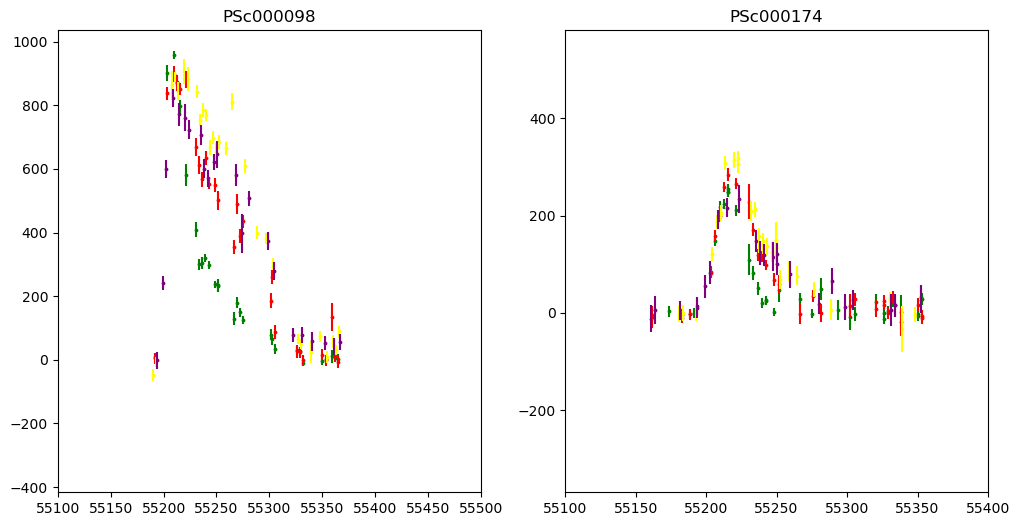

In [100]:
# plotting the data
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

colors = ['g', 'r', 'yellow', 'purple']

# psc98
for i, band in enumerate(psc_98bands):
    ax1.set_title("PSc000098")
    ax1.scatter(band['MJD'], band['FLUXCAL'],s=3, c=colors[i])
    ax1.errorbar(band['MJD'], band['FLUXCAL'], band['FLUXCALERR'], linestyle='None', c=colors[i])
    ax1.set_xlim(55100, 55500)
    
# psc174
for i, band in enumerate(psc_174bands):
    ax2.set_title("PSc000174")
    ax2.scatter(band['MJD'], band['FLUXCAL'],s=3, c=colors[i])
    ax2.errorbar(band['MJD'], band['FLUXCAL'], band['FLUXCALERR'], linestyle='None', c=colors[i])
    ax2.set_xlim(55100, 55400)

Since the bandpasses look similar,  I will use the same initial guess for all 4. My guesses, based on the parameter definitions in the paper, are:

$\begin{array}{c|c}
\text{Parameter} & \text{PSc 98} & \text{PSc 174} \\
\hline
A & 900 & 300 \\
\beta & -5 & -5 \\
t_0 & 55200 & 55210 \\
t_1 & 55300 & 55235 \\ 
\tau_{\text{rise}} & 1 & 2\\
\tau_{\text{fall}} & 2 & 250 \\
\end{array}$

PSc 98 seems to have a plateau and stark drop off, where PS 174 has curved peak and smooth fall. Using Figure 2 from Dr. Villar's paper, I made some estimate of the parameters. I just kept playing around with the parameters to get specific values above.

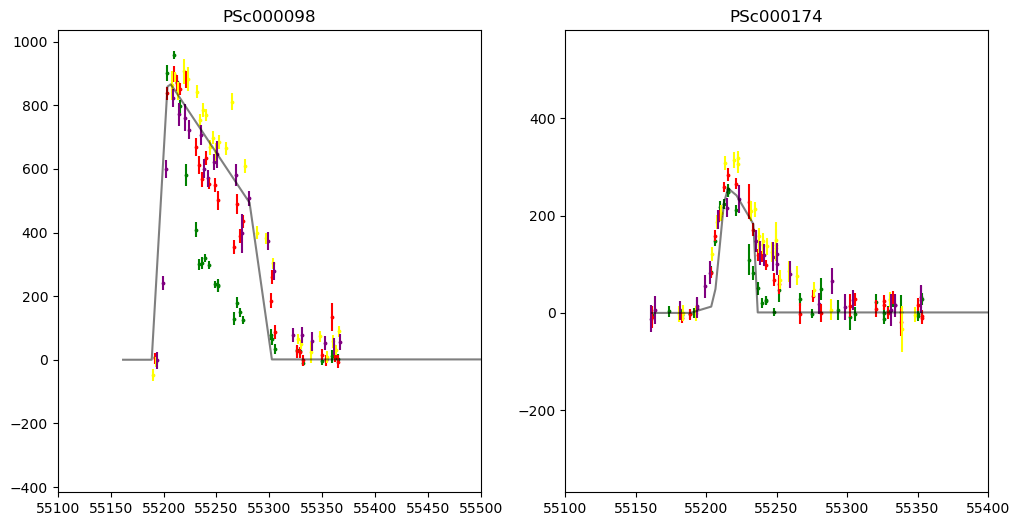

In [237]:
# plotting my guesses
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

colors = ['g', 'r', 'yellow', 'purple']
guess_98 = [900, -5, 55200, 55300, 1, 2]
guess_174 = [300, -5, 55210, 55235, 2, 250]

# psc98
for i, band in enumerate(psc_98bands):
    ax1.set_title("PSc000098")
    ax1.scatter(band['MJD'], band['FLUXCAL'],s=3, c=colors[i])
    ax1.errorbar(band['MJD'], band['FLUXCAL'], band['FLUXCALERR'], linestyle='None', c=colors[i])
    ax1.set_xlim(55100, 55500)
tmin, tmax = ax1.get_xlim()
tarr = np.arange(tmin, tmax+1,1)
ax1.plot(t, model(guess_98, t), c='black', alpha=0.5)
    
# psc174
for i, band in enumerate(psc_174bands):
    ax2.set_title("PSc000174")
    ax2.scatter(band['MJD'], band['FLUXCAL'],s=3, c=colors[i])
    ax2.errorbar(band['MJD'], band['FLUXCAL'], band['FLUXCALERR'], linestyle='None', c=colors[i])
    ax2.set_xlim(55100, 55400)

tmin, tmax = ax2.get_xlim()
tarr = np.arange(tmin, tmax+1,1)
ax2.plot(t, model(guess_174, t), c='black', alpha=0.5)

## Sampling

I will use emcee to sample the parameter space for each bandpass for both supernovae.

In [169]:
# testing with just one bandpass for now
data = psc_174bands[1]
t = np.array(data['MJD'])
F = data['FLUXCAL']
e = data['FLUXCALERR']

ndim = 6
args = (t, F, e)
sigmas = np.ones(ndim) # starting place for the parameters

nwalkers = 20
kwargs = {'t': t, 'F': F, 'e': e}

p0 = np.array(guess) + 0.1*sigmas*np.random.randn(nwalkers, ndim)

In [139]:
nburn = 1000
nsteps = 8000
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, kwargs=kwargs)
state = sampler.run_mcmc(p0, nburn)
sampler.reset()

sampler.run_mcmc(state, nsteps, progress=True); # suppress! its ugly

C:\Users\Haille Perkins\AppData\Local\Temp\ipykernel_16904\1170448404.py:29: RuntimeWarning: divide by zero encountered in log
  lnprior = np.log(p_A*p_beta*p_t0*p_gamma*p_rise*p_fall)
C:\Users\Haille Perkins\AppData\Local\Temp\ipykernel_16904\1206728205.py:4: RuntimeWarning: overflow encountered in exp
  return np.where(t < t1, (A + beta*(t-t0)) / (1 + np.exp(-(t-t0)/trise)), (1 + np.exp(-(t-t0)/trise)))
100%|██████████| 8000/8000 [05:50<00:00, 22.85it/s]


In [140]:
samples = sampler.get_chain(flat=True)
#samples = np.transpose(samples)
#for chain in samples:
    #print(np.median(chain))
print(np.percentile(samples, 50, axis=0))

[ 8.71885469e+02 -5.97290706e+00  5.51979478e+04  5.53038666e+04
  4.59674902e-01  1.47502298e+02]


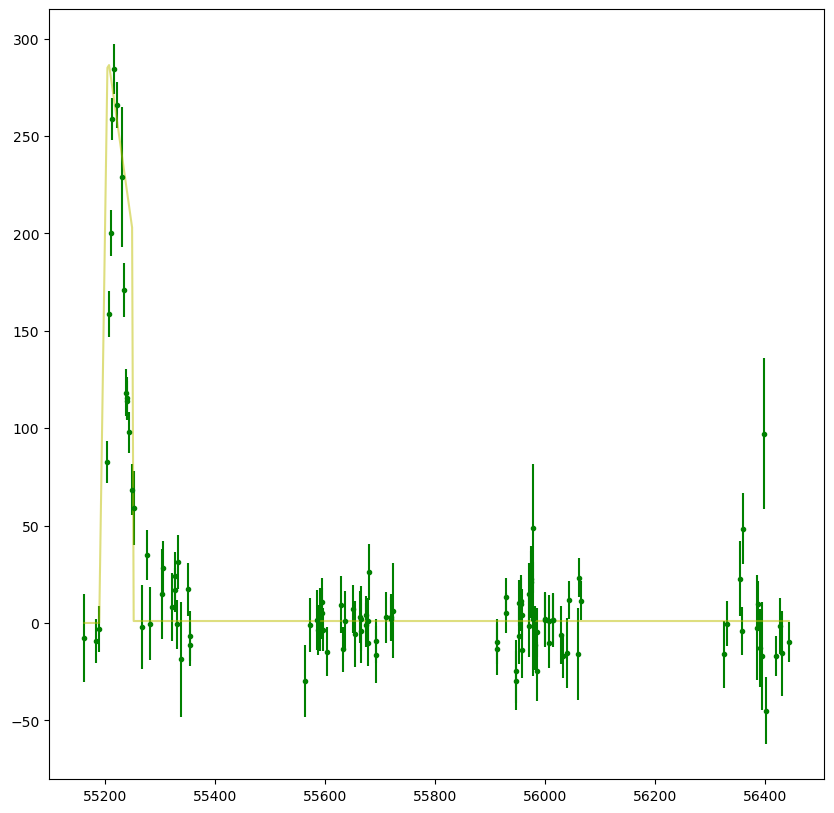

In [168]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.errorbar(t, F, e, linestyle='None', marker='.', c='g')
tmin, tmax = ax.get_xlim()
tarr = np.arange(tmin, tmax+1,1)
theta = np.percentile(samples, 50, axis=0)

#plt.plot(t, model(theta, t), c='g', alpha=0.5)

guess_174 = [300, -2, 55200, 55250, 1, 4]
plt.plot(t, model(guess_174, t), c='y', alpha=0.5)

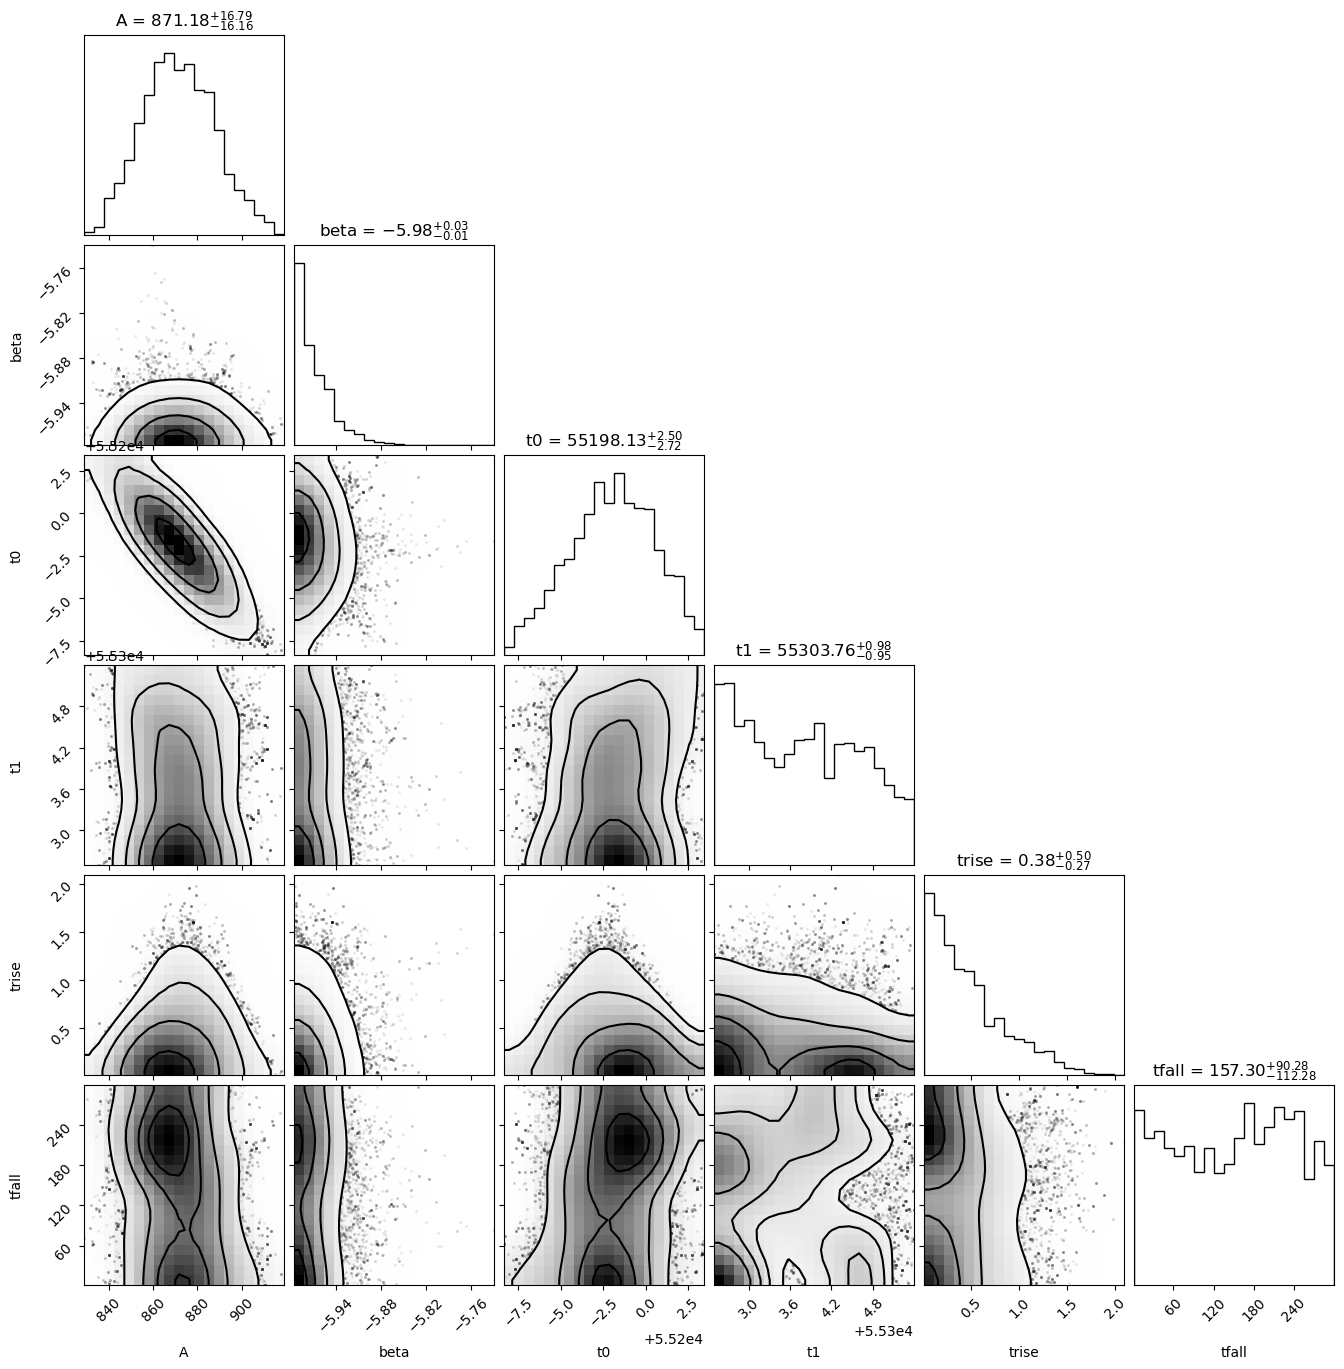

In [142]:
# note this is thinned
labels = ['A', 'beta', 't0', 't1', 'trise', 'tfall']
fig = corner.corner(samples[1000::10,:], plot_countours=True, show_titles=True, smooth=2, labels=labels)